In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from DF_functions import mean_msd,covariance_msd,theoretical_mean_msd,theoretical_covariance
from functions import data_pool,NormMSDSlopeError,NormMSDInterceptError,NormMSDSlopeError_exp,NormMSDInterceptError_exp,fix_heatmap
from sklearn.linear_model import LinearRegression

%matplotlib inline
%reload_ext autoreload

# Process raw data

Extract all of the features and relevant data from the TrackMate CSV files.

In [4]:
dt = 0.05
minframe=8
maxframe=500
rsquared_threshold=0.9

files1 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
images1 = ["Data/SM1/sm1_stack.tif","Data/SM2/sm2_stack.tif","Data/SM3/sm3_stack.tif","Data/SM4/sm4_stack.tif","Data/SM5/sm5_stack.tif","Data/SM6/sm6_stack.tif","Data/SM7/sm7_stack.tif","Data/SM8/sm8_stack.tif","Data/SM9/sm9_stack.tif","Data/SM10/sm10_stack.tif"]

files2 = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
images2 = ["Data/SM1_WNT/sm1_wnt_stack.tif","Data/SM2_WNT/sm2_wnt_stack.tif","Data/SM3_WNT/sm3_wnt_stack.tif","Data/SM4_WNT/sm4_wnt_stack.tif","Data/SM5_WNT/sm5_wnt_stack.tif","Data/SM6_WNT/sm6_wnt_stack.tif","Data/SM7_WNT/sm7_wnt_stack.tif","Data/SM8_WNT/sm8_wnt_stack.tif","Data/SM10_WNT/sm10_wnt_stack.tif"]

DATA1 = data_pool(files1,dt,minframe,maxframe,rsquared_threshold,images=images1,fit_option="thirty_percent")
DATA2 = data_pool(files2,dt,minframe,maxframe,rsquared_threshold,images=images2,fit_option="thirty_percent")

# Prepare DataFrames

Turn the extracted data into DataFrames. Apply filters, transform the data...

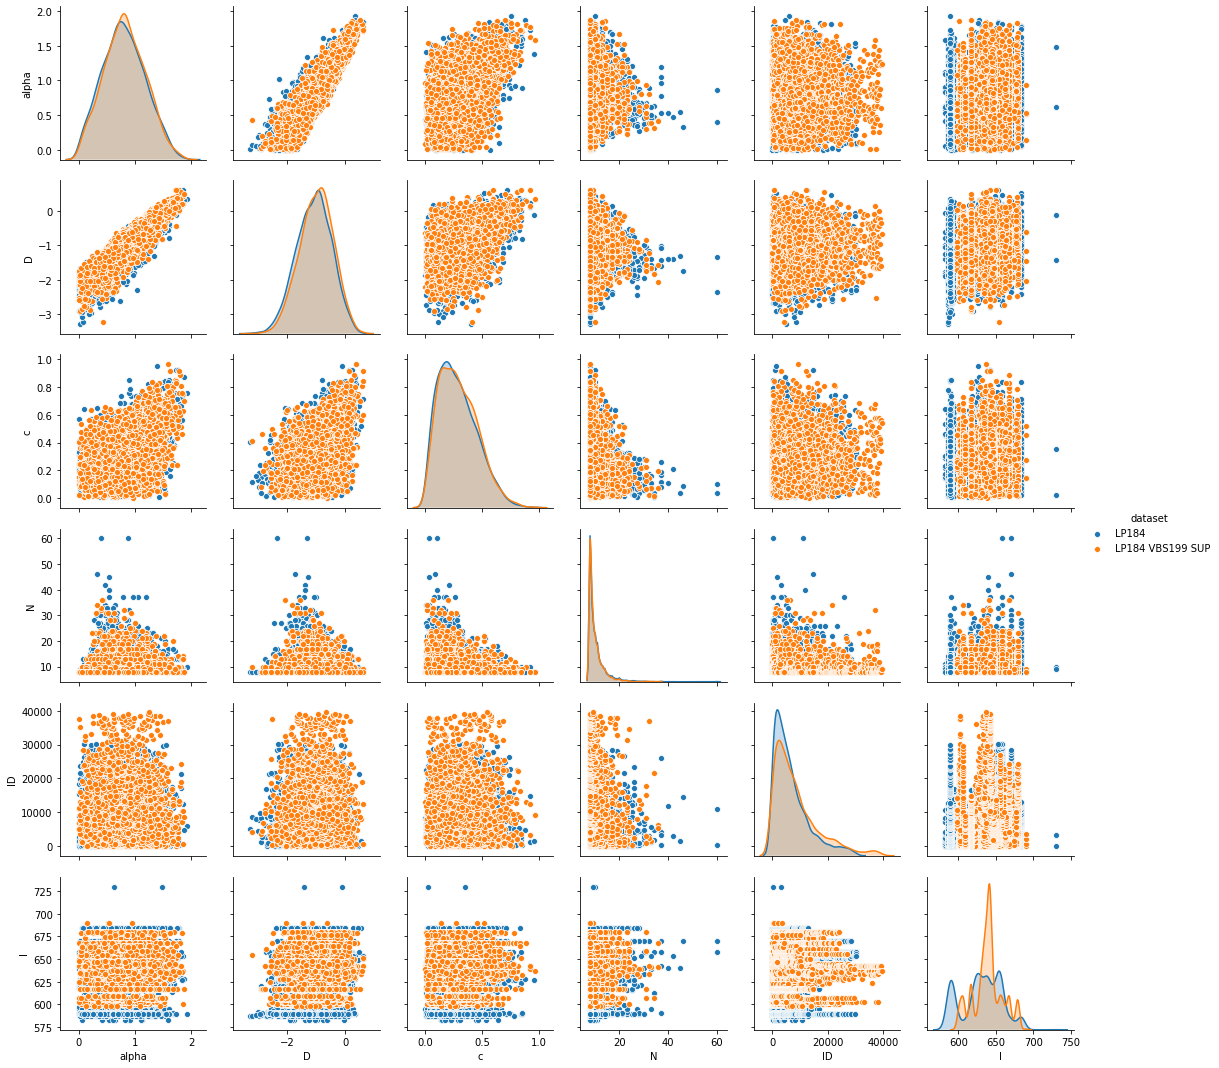

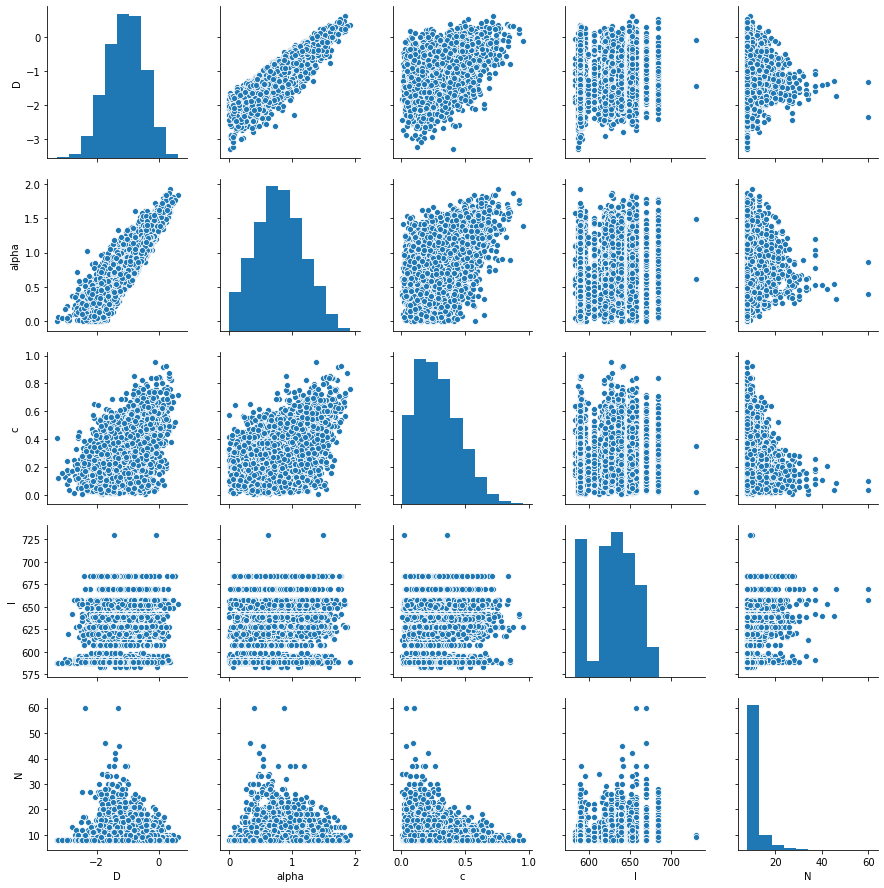

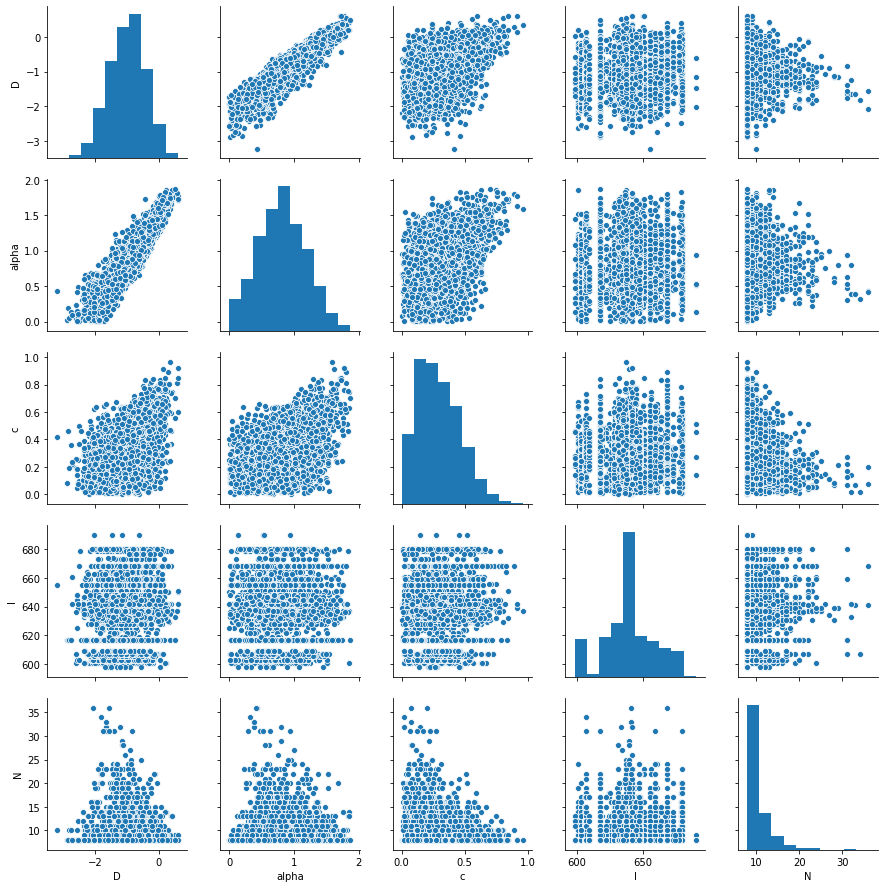

In [54]:
df1 = pd.DataFrame(DATA1,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
df2 = pd.DataFrame(DATA2,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
df1['D'] = df1['D'].map(lambda x: np.log10(x))
df2['D'] = df2['D'].map(lambda x: np.log10(x))

concatenated = pd.concat([df1.assign(dataset='LP184'), df2.assign(dataset='LP184 VBS199 SUP')])
sns.pairplot(concatenated,hue='dataset')
plt.show()

sns.pairplot(df1[['D','alpha','c','I','N']])
sns.pairplot(df2[['D','alpha','c','I','N']])

# MSD analysis on a DataFrame

Use any list of MSD curves to perform Michalet's analysis in order to extract the optimal free diffusion coefficient.

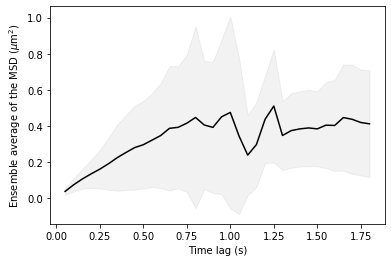

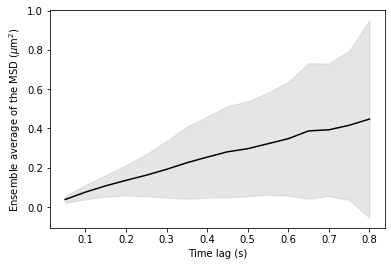

In [51]:
#Filter on alpha
dfilt1 = df1[(df1['alpha']<1.1) & (df1['alpha']>0.9)]
dfilt2 = df2[(df2['alpha']<1.1) & (df2['alpha']>0.9)]

#Select the Dataset and extract MSDs

DATASET = dfilt1
MSDSeries = DATASET['MSD'].values

sigma=0.3
D = 0.07
epsilon = 4*sigma**2
alpha = 4*D*dt
cutoff = 0.8

mmsd,mvar,timelag = mean_msd(MSDSeries,cutoff=cutoff)

plt.plot(timelag,mmsd,color='k')
plt.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(mmsd,mvar)],[a + np.sqrt(b) for a,b in zip(mmsd,mvar)], color="gray",alpha=0.2) 
plt.xlabel('Time lag (s)')
plt.ylabel('Ensemble average of the MSD ($\mu$m$^2$)')
plt.show()

In [52]:
covar = covariance_msd(MSDSeries,cutoff=cutoff)
N=len(mmsd)+1

for iteration in range(2):
    if iteration==0:
        print("Initial run to determine the best theoretical values for D and sigma.")
    if iteration==1:
        print("Second run with accurate values for D and sigma.")
    
    mmsd_th,mvar_th = theoretical_mean_msd(MSDSeries,D,sigma,cutoff=cutoff)
    covar_th = theoretical_covariance(MSDSeries,D,sigma,cutoff=cutoff)
    ###########################################
    ############### ERROR SLOPE ###############
    cut = int(cutoff/dt)
    Pmin_array = [int(p) for p in np.linspace(2,cut-2,cut-3)]
    sigmab_theory = []
    sigmab_exp_th = []
    sigmab_exp    = []

    for p in Pmin_array:
        sigmab_theory.append(NormMSDSlopeError(N,sigma,D,dt,p))
        sigmab_exp_th.append(NormMSDSlopeError_exp(N,sigma,D,dt,mvar_th,covar_th,p))
        sigmab_exp.append(NormMSDSlopeError_exp(N,sigma,D,dt,mvar,covar,p))

    min_y = min(sigmab_exp) 
    min_x = Pmin_array[sigmab_exp.index(min_y)]

    if iteration==0:
        print("It is estimated that the lowest error will be for a number of fitting points P = ",min_x," for which the relative error sigma/b = ",min_y)


    timelag = np.array(timelag)
    x = timelag.reshape((-1, 1))
    y = mmsd
    ctffb = int(min_x)
    model = LinearRegression().fit(x[:ctffb], y[:ctffb])
    r_sq = model.score(x[:ctffb], y[:ctffb])
    fit_b = model.predict(x)

    Dvalue = round(model.coef_[0]/4,4)
    print("D = ",Dvalue)
    Dvalue_error = round(min_y*model.coef_[0]/4,4)


    ###########################################
    ############### ERROR INTERCEPT ###############

    Pmin_array = [int(p) for p in np.linspace(2,cut-2,cut-3)]
    sigmaa_theory = []
    sigmaa_exp_th = []
    sigmaa_exp    = []
    for p in Pmin_array:
        sigmaa_theory.append(NormMSDInterceptError(N,sigma,D,dt,p))
        sigmaa_exp_th.append(NormMSDInterceptError_exp(N,sigma,D,dt,mvar_th,covar_th,p))
        sigmaa_exp.append(NormMSDInterceptError_exp(N,sigma,D,dt,mvar,covar,p))

    min_y = min(sigmaa_exp) 
    min_x = Pmin_array[sigmaa_exp.index(min_y)]

    if iteration==0:
        print("It is estimated that the lowest error will be when the number of fitting points P = ",min_x," for which the relative error sigmaa/a = ",min_y)

    timelag = np.array(timelag)
    xa = timelag.reshape((-1, 1))
    ya = mmsd
    ctffa = int(min_x)
    model = LinearRegression().fit(x[:ctffa], y[:ctffa])
    r_sq = model.score(x[:ctffa], y[:ctffa])
    fit_a = model.predict(x)

    loc_sigma = round(np.sqrt(model.intercept_/4),4)
    loc_sigma_error = round(min_y/2*model.intercept_,4)
    print("sigma = ",loc_sigma)
    
    D = Dvalue
    if np.isnan(loc_sigma)==True:
        print("sigma is nan. Replace with value close to zero.")
        sigma = 0.0000001
    else:
        sigma = loc_sigma

    epsilon = 4*sigma**2
    alpha = 4*D*dt
    if iteration==1:
        print("Done.")

Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  14  for which the relative error sigma/b =  1.288379976307566
D =  0.1372
It is estimated that the lowest error will be when the number of fitting points P =  3  for which the relative error sigmaa/a =  0.031186135015243758
sigma =  0.0314
Second run with accurate values for D and sigma.
D =  0.1372
sigma =  0.0314
Done.


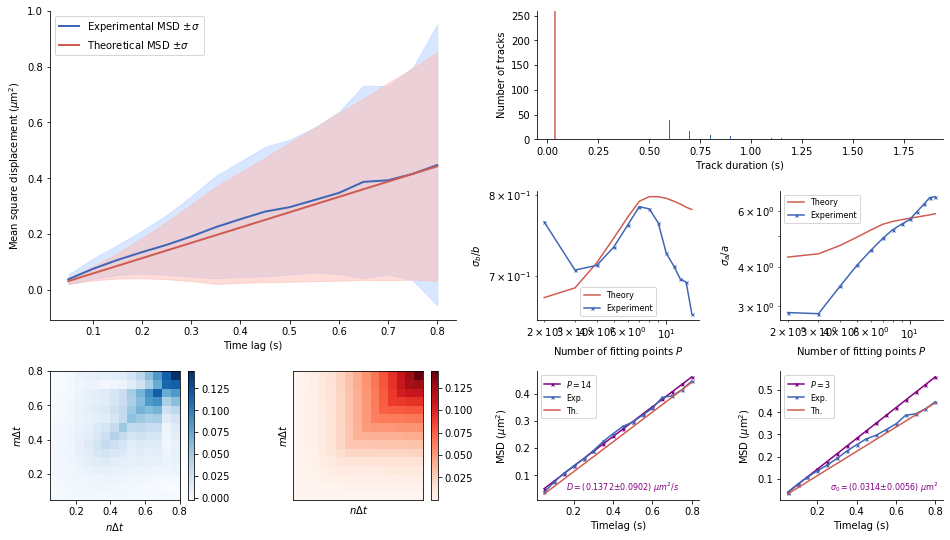

In [53]:
############## GLOBAL PLOT ###################################"

fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(3, 4, hspace=0.4, wspace=0.5)
msd_plot = fig.add_subplot(grid[0:2,0:2])
cov_exp = fig.add_subplot(grid[2,0])
cov_th  = fig.add_subplot(grid[2,1])
hist = fig.add_subplot(grid[0,2:4])
sigmab_err = fig.add_subplot(grid[1,2])
sigmaa_err = fig.add_subplot(grid[1,3])
D_plot = fig.add_subplot(grid[2,2])
loc_unc_plot = fig.add_subplot(grid[2,3])

cexp = "#3e66b5"
cth  = "#cf5c50"
msize = 3.0

######## MSD SUBPLOT #######################
msd_plot.spines["top"].set_visible(False)  
msd_plot.spines["right"].set_visible(False)
msd_plot.get_xaxis().tick_bottom()  
msd_plot.get_yaxis().tick_left()
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(mmsd,mvar)],[a + np.sqrt(b) for a,b in zip(mmsd,mvar)], color="#b3d1ff",alpha=0.5)
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(mmsd_th,mvar_th)],[a + np.sqrt(b) for a,b in zip(mmsd_th,mvar_th)], color="#febab3",alpha=0.5) 
msd_plot.plot(timelag,mmsd,color=cexp, lw=2,label="Experimental MSD $\pm \sigma $")
msd_plot.plot(timelag,mmsd_th,color=cth, lw=2,label="Theoretical MSD $\pm \sigma $")
msd_plot.set_ylabel(r"Mean square displacement ($\mu$m$^2$)",fontsize=10)
msd_plot.set_xlabel('Time lag (s)',fontsize=10)
msd_plot.legend(loc="upper left",fontsize=10)

########## HISTOGRAM ########################"
N_array = [len(msd)+1 for msd in MSDSeries]
hist.spines["top"].set_visible(False)  
hist.spines["right"].set_visible(False)
hist.get_xaxis().tick_bottom()  
hist.get_yaxis().tick_left()
hist_array = [n*dt for n in N_array]
hist.hist(hist_array,color=cexp, bins=int(len(N_array)))
hist.axvline(cutoff*dt, 0, max(hist_array),color=cth)
hist.set_xlabel('Track duration (s)',fontsize=10)
hist.set_ylabel('Number of tracks',fontsize=10)

######## COVARIANCE #############################

im1 = cov_exp.pcolormesh(timelag,timelag,covar,cmap="Blues")
cov_exp.set_xlabel(r'$n \Delta t$')
cov_exp.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im1,ax=cov_exp)
#plt.title('Map of experimental covariance values')

im2 = cov_th.pcolormesh(timelag,timelag,covar_th,cmap="Reds")
#cov_th.colorbar()
cov_th.set_xticks([])
cov_th.set_yticks([])
cov_th.set_xlabel(r'$n \Delta t$')
cov_th.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im2,ax=cov_th)
#cov_th.set_title('Map of theoretical covariance values')


############## ERRORS ###################################
sigmab_err.spines["top"].set_visible(False)  
sigmab_err.spines["right"].set_visible(False)
sigmab_err.get_xaxis().tick_bottom()  
sigmab_err.get_yaxis().tick_left()
sigmab_err.loglog(Pmin_array,sigmab_exp_th,label="Theory",color=cth)
sigmab_err.loglog(Pmin_array,sigmab_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmab_err.set_xlabel('Number of fitting points $P$')
sigmab_err.set_ylabel(r'$\sigma_b / b$')
sigmab_err.legend(fontsize=8)

sigmaa_err.spines["top"].set_visible(False)  
sigmaa_err.spines["right"].set_visible(False)
sigmaa_err.get_xaxis().tick_bottom()  
sigmaa_err.get_yaxis().tick_left()
sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,label="Theory",color=cth)
#sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,".",label="Control_theory from matrices")
sigmaa_err.loglog(Pmin_array,sigmaa_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmaa_err.set_xlabel('Number of fitting points $P$')
sigmaa_err.set_ylabel(r'$\sigma_a / a$')
sigmaa_err.legend(fontsize=8)

############" LINEAR FITS ######################################
D_plot.spines["top"].set_visible(False)  
D_plot.spines["right"].set_visible(False)
D_plot.get_xaxis().tick_bottom()  
D_plot.get_yaxis().tick_left()
D_plot.plot(x, fit_b,"-x",label=r'$P = $'+str(ctffb),color="purple",ms=msize)
D_plot.plot(timelag,mmsd,"-x",label="Exp.",color=cexp,ms=msize)
D_plot.plot(timelag,mmsd_th,label="Th.",color=cth)
D_plot.legend(loc="upper left",fontsize=8)
D_plot.set_xlabel('Timelag (s)')
D_plot.set_ylabel(r'MSD ($\mu$m$^2$)')
D_plot.text(max(timelag)/5,max(mmsd)/10,r'$D = ($'+str(Dvalue)+"$\pm$"+str(Dvalue_error)+") $\mu m^2 / s$",color="purple",fontsize=8)

loc_unc_plot.spines["top"].set_visible(False)  
loc_unc_plot.spines["right"].set_visible(False)
loc_unc_plot.get_xaxis().tick_bottom()  
loc_unc_plot.get_yaxis().tick_left()
loc_unc_plot.plot(x, fit_a,"-x",label=r'$P = $'+str(ctffa),color="purple",ms=msize)
loc_unc_plot.plot(timelag,mmsd,"x-",label="Exp.",color=cexp,ms=msize)
loc_unc_plot.plot(timelag,mmsd_th,label="Th.",color=cth)
loc_unc_plot.legend(loc="upper left",fontsize=8)
loc_unc_plot.set_xlabel('Timelag (s)')
loc_unc_plot.set_ylabel(r'MSD ($\mu$m$^2$)')
loc_unc_plot.text(max(timelag)/3,max(mmsd)/10,r'$\sigma_0 = ($'+str(loc_sigma)+"$\pm$"+str(loc_sigma_error)+") $\mu$m$^2$",color="purple",fontsize=8)

plt.show()